In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/datasets')
print(os.getcwd())

/content/drive/MyDrive/datasets


## 1. American Sign Language (ASL)
<p>American Sign Language (ASL) is the primary language used by many deaf individuals in North America, and it is also used by hard-of-hearing and hearing individuals.  The language is as rich as spoken languages and employs signs made with the hand, along with facial gestures and bodily postures.</p>
<p><img src="https://assets.datacamp.com/production/project_509/img/asl.png" alt="american sign language"></p>
<p>A lot of recent progress has been made towards developing computer vision systems that translate sign language to spoken language.  This technology  often relies on complex neural network architectures that can detect subtle patterns in streaming video.  However, as a first step, towards understanding how to build a translation system, we can reduce the size of the problem by translating individual letters, instead of sentences.</p>
<p><strong>In this notebook</strong>, we will train a convolutional neural network to classify images of American Sign Language (ASL) letters.  After loading, examining, and preprocessing the data, we will train the network and test its performance.</p>
<p>In the code cell below, we load the training and test data. </p>
<ul>
<li><code>x_train</code> and <code>x_test</code> are arrays of image data with shape <code>(num_samples, 3, 50, 50)</code>, corresponding to the training and test datasets, respectively.</li>
<li><code>y_train</code> and <code>y_test</code> are arrays of category labels with shape <code>(num_samples,)</code>, corresponding to the training and test datasets, respectively.</li>
</ul>

In [3]:
# Import packages and set numpy random seed
import numpy as np
np.random.seed(5)
import tensorflow as tf
tf.random.set_seed(2)
import matplotlib.pyplot as plt
%matplotlib inline

# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Define dataset path
dataset_path = '/content/drive/MyDrive/dataset'

# Load your dataset
from drive.MyDrive.datasets import sign_language

# Load pre-shuffled training and test datasets
(x_train, y_train), (x_test, y_test) = sign_language.load_data()

In [4]:
import os
print(os.listdir('/content/drive/MyDrive/datasets/A'))

['A31.jpg', 'A618.jpg', 'A142.jpg', 'A25.jpg', 'A340.jpg', 'A552.jpg', 'A156.jpg', 'A19.jpg', 'A426.jpg', 'A546.jpg', 'A181.jpg', 'A208.jpg', 'A624.jpg', 'A383.jpg', 'A195.jpg', 'A630.jpg', 'A585.jpg', 'A354.jpg', 'A220.jpg', 'A432.jpg', 'A397.jpg', 'A591.jpg', 'A778.jpg', 'A368.jpg', 'A817.jpg', 'A803.jpg', 'A234.jpg', 'A584.jpg', 'A209.jpg', 'A221.jpg', 'A745.jpg', 'A988.jpg', 'A355.jpg', 'A792.jpg', 'A962.jpg', 'A396.jpg', 'A235.jpg', 'A779.jpg', 'A977.jpg', 'A382.jpg', 'A963.jpg', 'A744.jpg', 'A989.jpg', 'A590.jpg', 'A976.jpg', 'A786.jpg', 'A793.jpg', 'A751.jpg', 'A787.jpg', 'A750.jpg', 'A433.jpg', 'A547.jpg', 'A553.jpg', 'A26.jpg', 'A32.jpg', 'A1.jpg', 'A633.jpg', 'A143.jpg', 'A141.jpg', 'A427.jpg', 'A627.jpg', 'A157.jpg', 'A625.jpg', 'A3.jpg', 'A619.jpg', 'A24.jpg', 'A341.jpg', 'A194.jpg', 'A30.jpg', 'A631.jpg', 'A169.jpg', 'A18.jpg', 'A816.jpg', 'A802.jpg', 'A180.jpg', 'A369.jpg', 'A155.jpg', 'A753.jpg', 'A828.jpg', 'A380.jpg', 'A800.jpg', 'A579.jpg', 'A784.jpg', 'A425.jpg', 'A1

## 2. Visualize the training data
<p>Now we'll begin by creating a list of string-valued labels containing the letters that appear in the dataset.  Then, we visualize the first several images in the training data, along with their corresponding labels.</p>

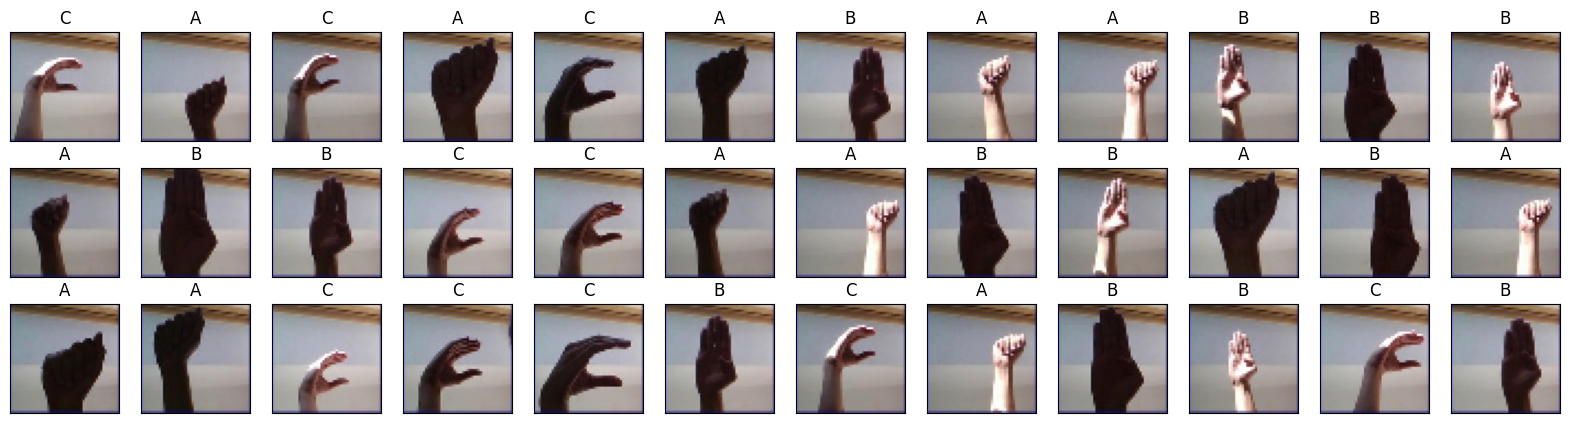

In [5]:
# Store labels of dataset
labels = ['A','B','C']

# Print the first several training images, along with the labels
fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))
    ax.set_title("{}".format(labels[y_train[i]]))
plt.show()

## 3. Examine the dataset
<p>Let's examine how many images of each letter can be found in the dataset.</p>
<p>Remember that dataset has already been split into training and test sets for you, where <code>x_train</code> and <code>x_test</code> contain the images, and <code>y_train</code> and <code>y_test</code> contain their corresponding labels.</p>
<p>Each entry in <code>y_train</code> and <code>y_test</code> is one of <code>0</code>, <code>1</code>, or <code>2</code>, corresponding to the letters <code>'A'</code>, <code>'B'</code>, and <code>'C'</code>, respectively.</p>
<p>We will use the arrays <code>y_train</code> and <code>y_test</code> to verify that both the training and test sets each have roughly equal proportions of each letter.</p>

In [6]:
# Number of A's in the training dataset
num_A_train = np.sum(y_train==0)
# Number of B's in the training dataset
num_B_train = np.sum(y_train==1)
# Number of C's in the training dataset
num_C_train = np.sum(y_train==2)

# Number of A's in the test dataset
num_A_test = np.sum(y_test==0)
# Number of B's in the test dataset
num_B_test = np.sum(y_test==1)
# Number of C's in the test dataset
num_C_test = np.sum(y_test==2)

# Print statistics about the dataset
print("Training set:")
print("\tA: {}, B: {}, C: {}".format(num_A_train, num_B_train, num_C_train))
print("Test set:")
print("\tA: {}, B: {}, C: {}".format(num_A_test, num_B_test, num_C_test))

Training set:
	A: 540, B: 528, C: 532
Test set:
	A: 118, B: 144, C: 138


## 4. One-hot encode the data
<p>Currently, our labels for each of the letters are encoded as categorical integers, where <code>'A'</code>, <code>'B'</code> and <code>'C'</code> are encoded as <code>0</code>, <code>1</code>, and <code>2</code>, respectively.  However, recall that Keras models do not accept labels in this format, and we must first one-hot encode the labels before supplying them to a Keras model.</p>
<p>This conversion will turn the one-dimensional array of labels into a two-dimensional array.</p>
<p><img src="https://assets.datacamp.com/production/project_509/img/onehot.png" alt="one-hot encoding"></p>
<p>Each row in the two-dimensional array of one-hot encoded labels corresponds to a different image.  The row has a <code>1</code> in the column that corresponds to the correct label, and <code>0</code> elsewhere.  </p>
<p>For instance, </p>
<ul>
<li><code>0</code> is encoded as <code>[1, 0, 0]</code>, </li>
<li><code>1</code> is encoded as <code>[0, 1, 0]</code>, and </li>
<li><code>2</code> is encoded as <code>[0, 0, 1]</code>.</li>
</ul>

In [8]:
from keras.utils import to_categorical

# One-hot encode the training labels
y_train_OH = to_categorical(y_train)

# One-hot encode the test labels
y_test_OH = to_categorical(y_test)

## 5. Define the model
<p>Now it's time to define a convolutional neural network to classify the data.</p>
<p>This network accepts an image of an American Sign Language letter as input.  The output layer returns the network's predicted probabilities that the image belongs in each category.</p>

In [9]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense
from keras.models import Sequential

model = Sequential()
# First convolutional layer accepts image input
model.add(Conv2D(filters=5, kernel_size=5, padding='same', activation='relu',
                        input_shape=(50, 50, 3)))
# Add a max pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))
# Add a convolutional layer
model.add(Conv2D(filters=10, kernel_size=3, padding="same",activation="relu"))
# Add another max pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))
# Flatten and feed to output layer
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

# Summarize the model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 50, 50, 5)           │             380 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 25, 25, 5)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 25, 25, 10)          │             460 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1440)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           4,323 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,163 (20.17 KB)

 Trainable params: 5,163 (20.17 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Compile the model
<p>After we have defined a neural network in Keras, the next step is to compile it! </p>

In [14]:
# Compile the model
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Define callbacks for training
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001, verbose=1)

# Lists to track training and validation metrics for visualization
train_loss = []
val_loss = []
train_acc = []
val_acc = []

## 7. Train the model
<p>Once we have compiled the model, we're ready to fit it to the training data.</p>

In [15]:
# Train the model
history = model.fit(x_train, y_train_OH, batch_size=32, epochs=10, validation_data=(x_test, y_test_OH), callbacks = ([checkpoint, early_stop, reduce_lr]))

# Update lists with training and validation metrics
train_loss.extend(history.history['loss'])
val_loss.extend(history.history['val_loss'])
train_acc.extend(history.history['accuracy'])
val_acc.extend(history.history['val_accuracy'])


Epoch 1/10
42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4373 - loss: 1.0366
Epoch 1: val_loss improved from inf to 0.63475, saving model to model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.4610 - loss: 1.0134 - val_accuracy: 0.7100 - val_loss: 0.6347 - learning_rate: 0.0010
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7585 - loss: 0.5603
Epoch 2: val_loss improved from 0.63475 to 0.32287, saving model to model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7592 - loss: 0.5588 - val_accuracy: 0.8925 - val_loss: 0.3229 - learning_rate: 0.0010
Epoch 3/10
47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8938 - loss: 0.3081
Epoch 3: val_loss improved from 0.32287 to 0.16690, saving model to model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8956 - loss: 0.3044 - val_accuracy: 0.9700 - val_loss: 0.1669 - learning_rate: 0.0010
Epoch 4/10
26/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9557 - loss: 0.1839  
Epoch 4:

## 8. Test the model
<p>To evaluate the model, we'll use the test dataset.  This will tell us how the network performs when classifying images it has never seen before!</p>
<p>If the classification accuracy on the test dataset is similar to the training dataset, this is a good sign that the model did not overfit to the training data.  </p>

In [16]:
# Obtain accuracy on test set
score = model.evaluate(x=x_test,
                       y=y_test_OH,
                       verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 1.0


## 9. Visualize mistakes
<p>Hooray!  Our network gets very high accuracy on the test set!  </p>
<p>The final step is to take a look at the images that were incorrectly classified by the model.  Do any of the mislabeled images look relatively difficult to classify, even to the human eye?  </p>
<p>Sometimes, it's possible to review the images to discover special characteristics that are confusing to the model.  However, it is also often the case that it's hard to interpret what the model had in mind!</p>

In [17]:
# Get predicted probabilities for test dataset
y_probs = model.predict(x_test)

# Get predicted labels for test dataset
y_preds = np.argmax(y_probs,axis=1)

# Indices corresponding to test images which were mislabeled
bad_test_idxs = np.where(y_preds != np.argmax(y_test_OH, axis=1))[0]

# Print mislabeled examples
fig = plt.figure(figsize=(25,4))
for i, idx in enumerate(bad_test_idxs):
    ax = fig.add_subplot(2, np.ceil(len(bad_test_idxs)/2), i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    ax.set_title("{} (pred: {})".format(labels[y_test[idx]], labels[y_preds[idx]]))

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


<Figure size 2500x400 with 0 Axes>

# 10. Plotting Training and Validation Metrics
Now that we have explored the mistakes, let's visualize the training and validation metrics to get a better understanding of the model's performance over the course of training. We'll plot the following graphs:

- `Loss Curve:` A plot of the training and validation loss over epochs. This helps us see how the model's error decreases as it learns, and whether it's overfitting or underfitting.

- `Accuracy Curve:` A plot of the training and validation accuracy over epochs. This will show how well the model is performing at predicting the correct class and whether the model is generalizing well to the validation set.

These graphs will provide valuable insights into the training dynamics and whether further adjustments (e.g., early stopping, learning rate tuning) are needed.

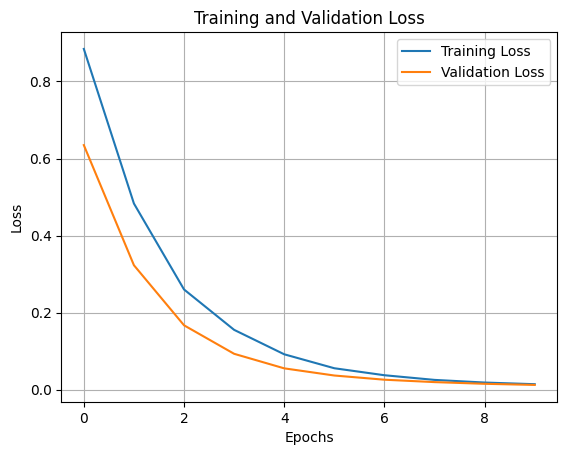

In [18]:
import matplotlib.pyplot as plt

#Plotting Loss Curve
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

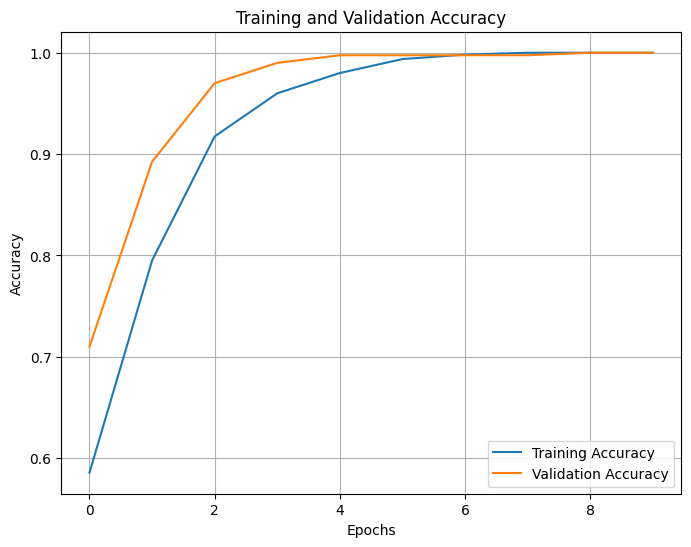

In [19]:
#Plotting accuracy Curve

plt.figure(figsize=(8, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()